In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
palette = 'viridis'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

clients = pd.read_csv('https://raw.githubusercontent.com/kuwaitikiwi/edgered-interview/main/Clients.csv')
df = pd.read_csv('https://raw.githubusercontent.com/kuwaitikiwi/edgered-interview/main/Payments.csv')
print(len(df))
#assign the corresponding entity_type, entity_year_established for each client_id in each row of the raw dataframe
df['entity_type'] = df['client_id'].map(clients['entity_type'])
df['entity_year_established'] = df['client_id'].map(clients['entity_year_established'])


df.describe()

25559


,transaction_id,contract_id,client_id,transaction_date,payment_amt,entity_year_established
count,25559.000000,25559.000000,25559.000000,2.555900e+04,25559.000000,25559.000000
mean,12780.000000,758.221409,602.886811,1.517126e+09,1221.455691,2009.073751
std,7378.392101,352.190207,344.782295,9.964331e+06,4346.049363,5.692206
min,1.000000,1.000000,1.000000,1.499019e+09,-136.660000,1999.000000
25%,6390.500000,510.000000,308.000000,1.508433e+09,93.330000,2004.000000
50%,12780.000000,732.000000,593.000000,1.518110e+09,266.660000,2010.000000
75%,19169.500000,991.000000,894.000000,1.525976e+09,833.330000,2014.000000
max,25559.000000,1643.000000,1281.000000,1.532456e+09,200000.050000,2018.000000


### Cleaning
- Assigned entity_type and entity_year_established to each transaction based on client_id
- Converted EPOCH time to human readable time
- Remove all entries with same column values except for transaction_id
- Removed outliers (> 95th percentile) in payment_amt, as it is clear there are outliers ($200000 compared to $4000 mean)

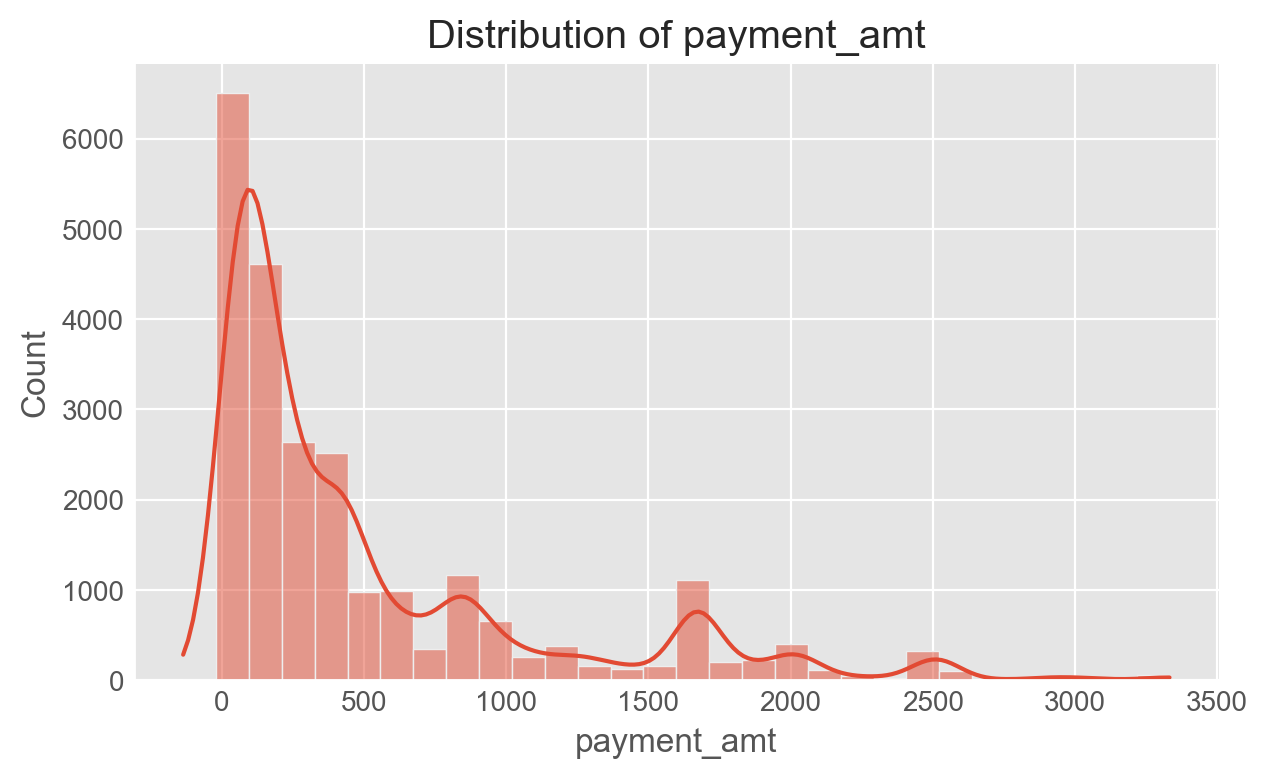

<AxesSubplot: >

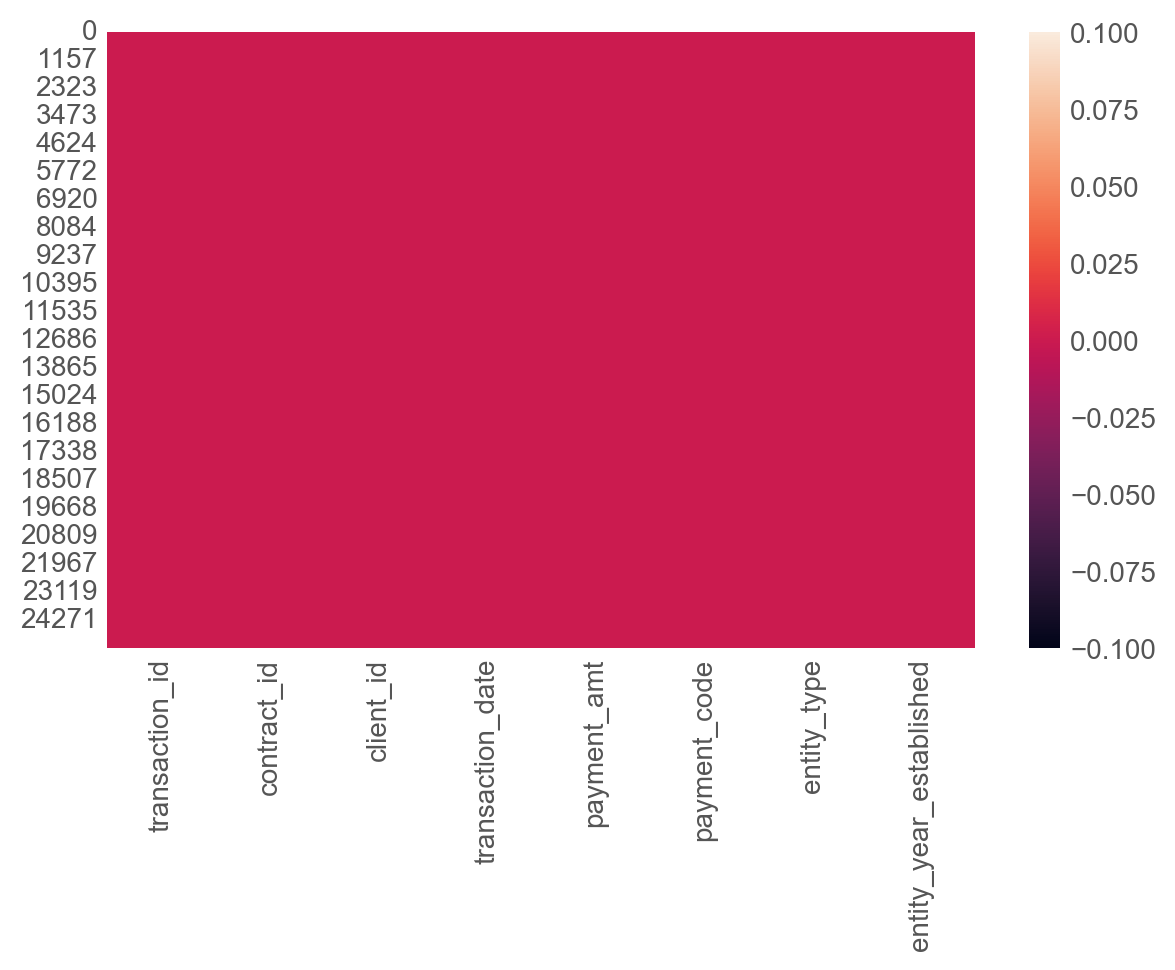

In [59]:
df.transaction_date = df.transaction_date.apply(lambda test: dt.datetime.fromtimestamp(test).strftime('%Y-%m-%d %H:%M:%S'))

df = df.drop_duplicates(subset=['transaction_date','payment_amt','client_id','payment_code'])


df.drop(df[df['payment_amt']>df.payment_amt.quantile(0.95)].index, inplace=True)

plt.figure(figsize=(7,4))
sns.histplot(df['payment_amt'], kde=True, bins=30, palette = 'viridis')
plt.title('Distribution of payment_amt')
plt.show()

df.dropna(inplace=True)
plt.figure(figsize=(7,4))
sns.heatmap(df.isnull(), cbar=True)


## EDA

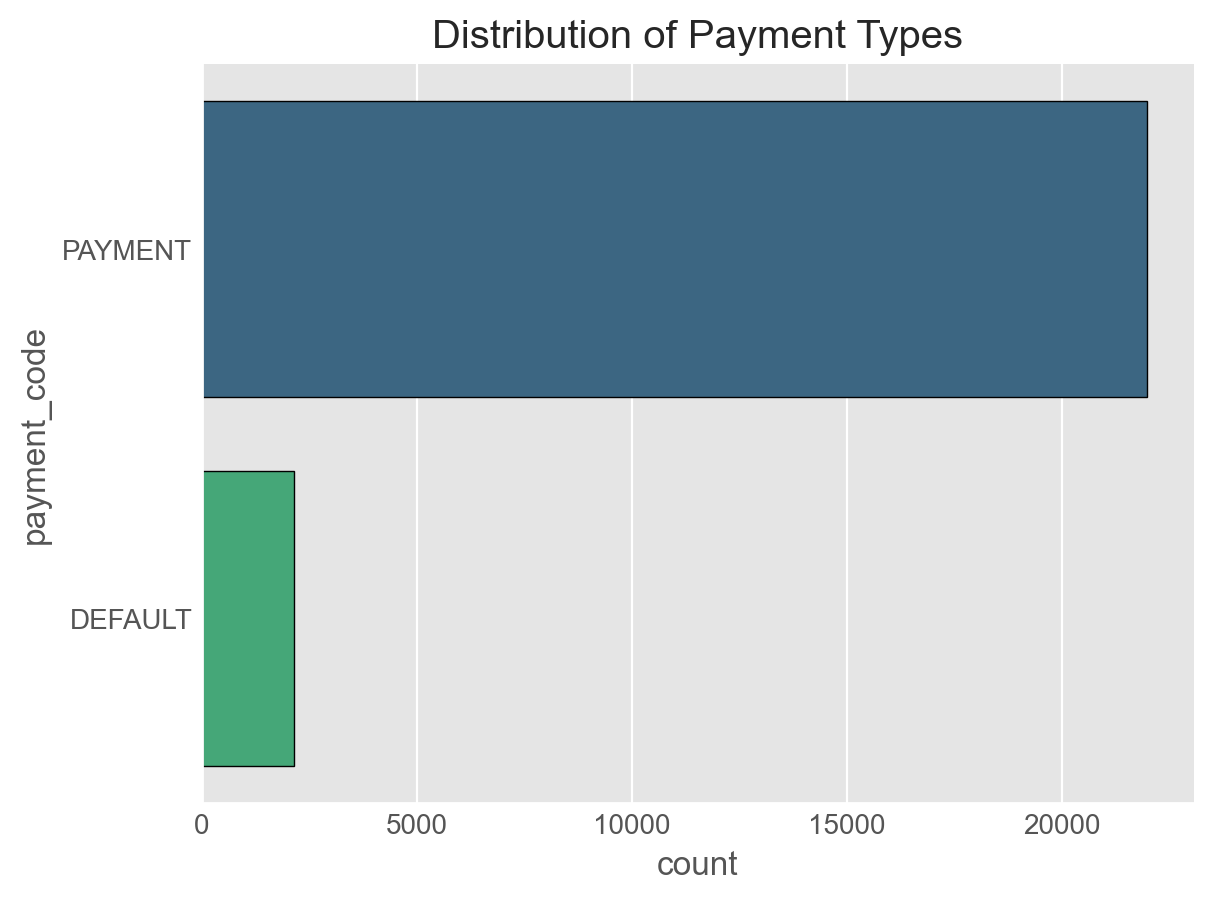

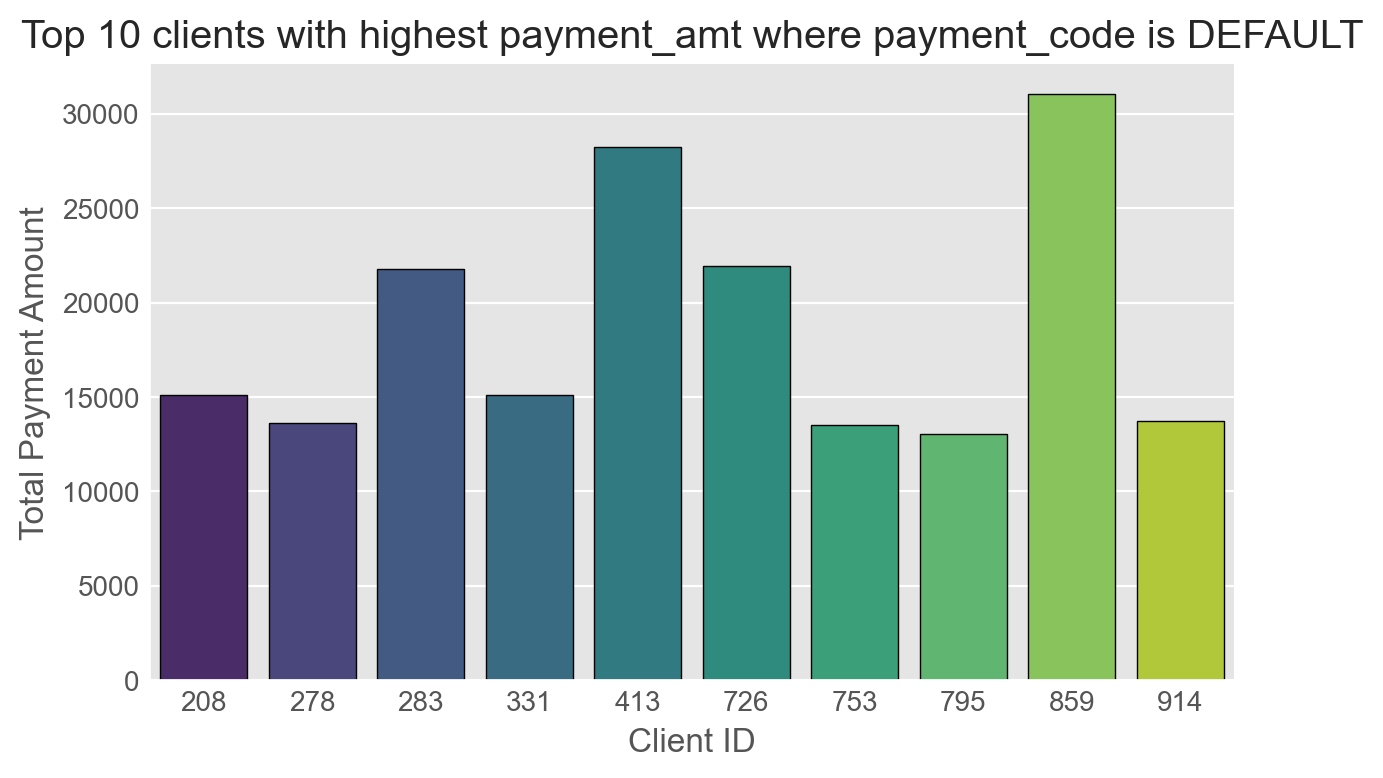

In [60]:
sns.countplot(data=df, y='payment_code', palette=palette, edgecolor='black')
plt.title('Distribution of Payment Types')
plt.show()

# plot top 10 clients with highest payment_amt where payment_code is 'DEFAULT'
plt.figure(figsize=(7, 4))
data = df[df['payment_code'] == 'DEFAULT'].groupby('client_id')['payment_amt'].sum().nlargest(10).reset_index()
sns.barplot(data=data, x='client_id', y='payment_amt', palette=palette,edgecolor='black')
plt.xlabel('Client ID') 
plt.ylabel('Total Payment Amount')
plt.title('Top 10 clients with highest payment_amt where payment_code is DEFAULT')
plt.show()


### Payment Amount and Default
- To determine whether payment method is a good predictor of default, we will compare whether there is significant difference in payment amount between default and non-default groups.
- Depending on the distribution of payment amount, we will use either t-test or Mann-Whitney U test to compare the means of payment amount between default and non-default groups.
- $H_0: \mu_{\text{default}} = \mu_{\text{non-default}}$ $H_1: \mu_{\text{default}} \neq \mu_{\text{non-default}}$
- Outliers are removed from the payment amount data to ensure that the test is not affected by extreme values.

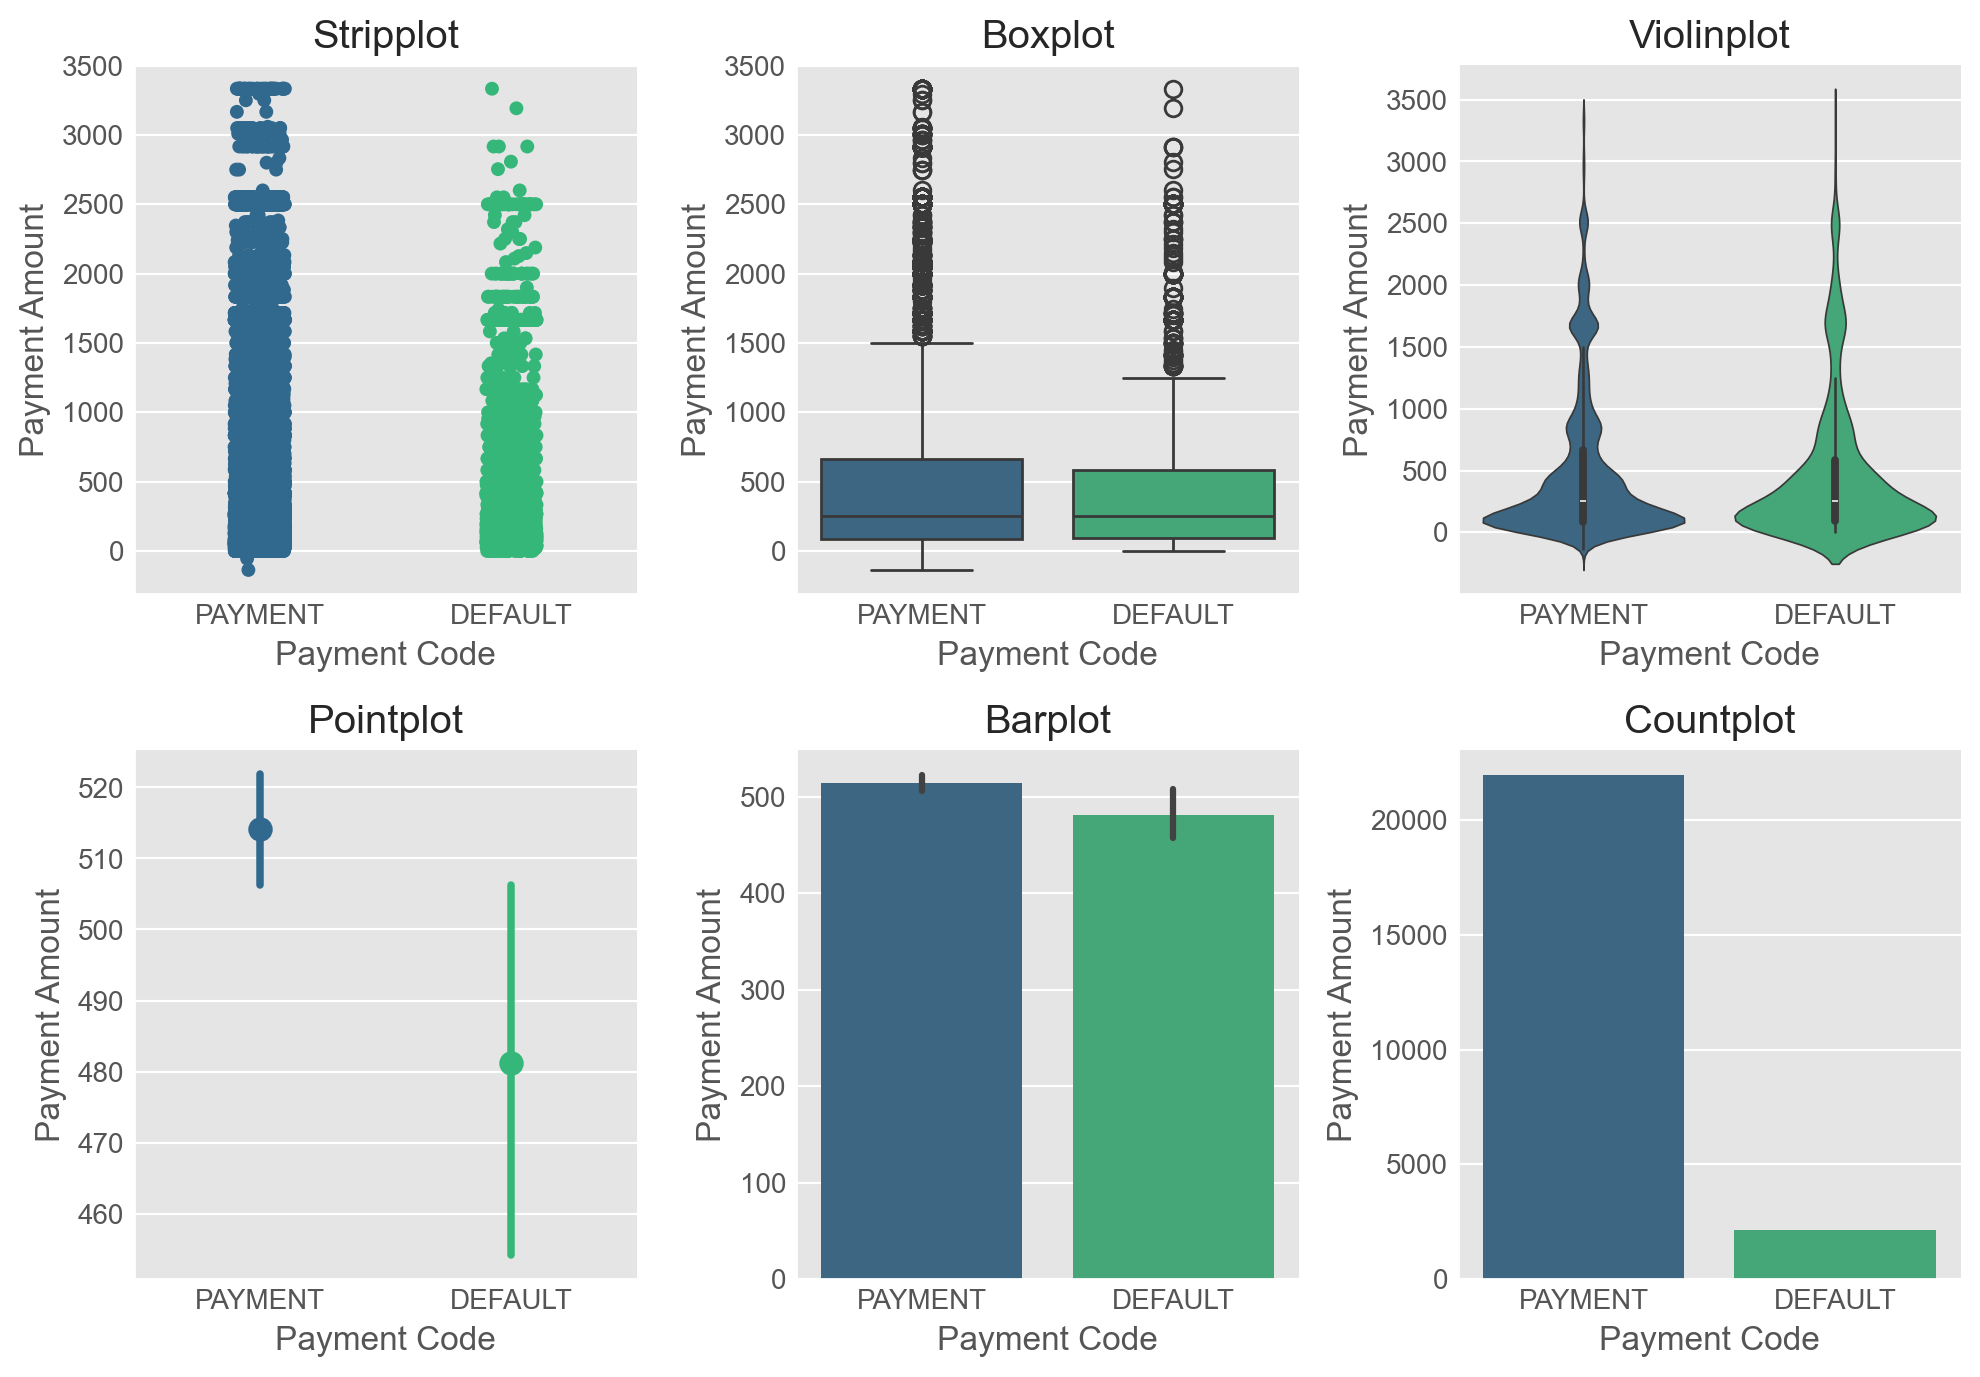

In [63]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7))

sns.stripplot(x="payment_code", y="payment_amt", data=df, ax=axs[0, 0],palette=palette)
axs[0, 0].set_title('Stripplot')

# distribution plots
sns.boxplot(x="payment_code", y="payment_amt", data=df, ax=axs[0, 1],palette=palette)
axs[0, 1].set_title('Boxplot')

sns.violinplot(x="payment_code", y="payment_amt", data=df, ax=axs[0, 2],palette=palette)
axs[0, 2].set_title('Violinplot')

# categorical estimate plots
sns.pointplot(x="payment_code", y="payment_amt", data=df, ax=axs[1, 0],palette=palette)
axs[1, 0].set_title('Pointplot')

sns.barplot(x="payment_code", y="payment_amt", data=df, ax=axs[1, 1],palette=palette)
axs[1, 1].set_title('Barplot')

sns.countplot(x="payment_code", data=df, ax=axs[1, 2],palette=palette)
axs[1, 2].set_title('Countplot')

for ax in axs.flat:
    ax.set_ylabel('Payment Amount')
    ax.set_xlabel('Payment Code')

plt.tight_layout()
plt.show()


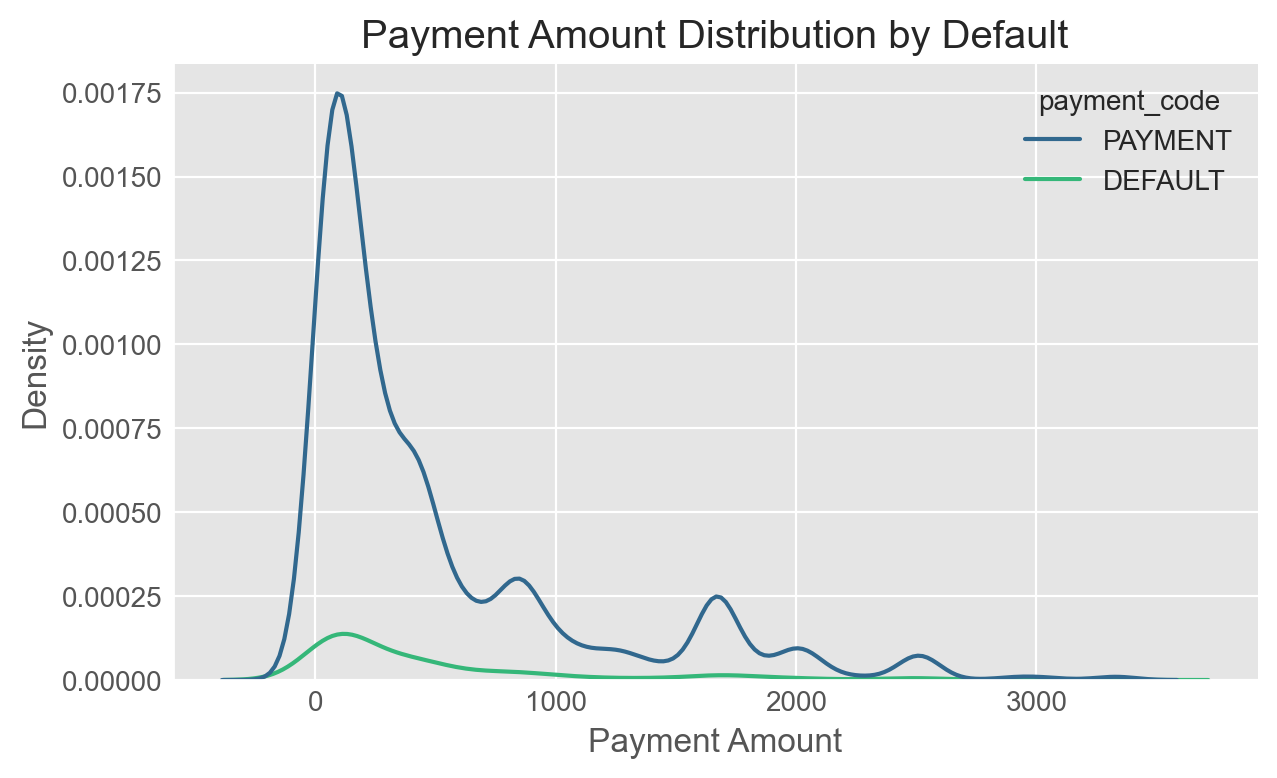

C:\Users\85295\AppData\Local\Temp\ipykernel_107944\316859757.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='payment_amt', y='payment_code', data=df, palette=palette)


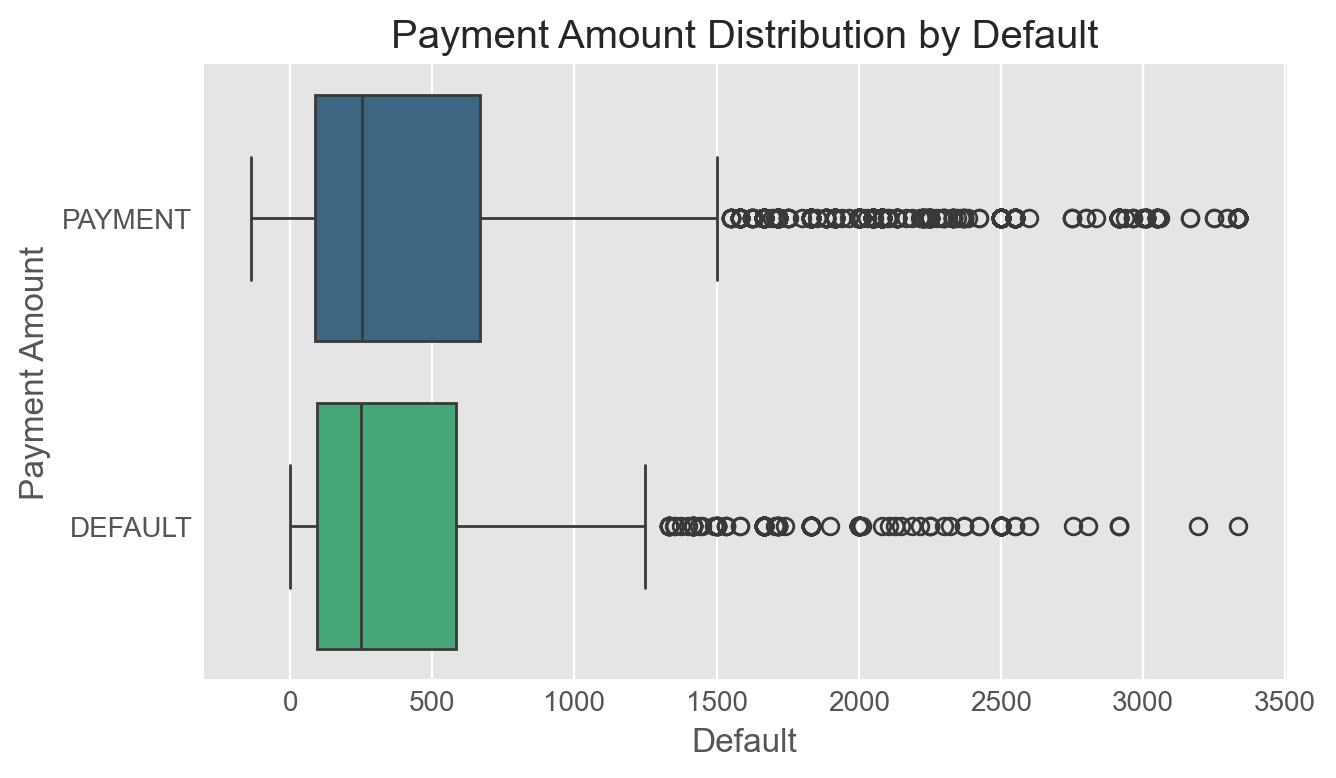

In [35]:
df['default'] = df.payment_code.apply(lambda x: 1 if x == 'DEFAULT' else 0)
df['default'] = df['default'].astype('category')
df['payment_amt'] = df['payment_amt'].astype('float')


plt.figure(figsize=(7,4))
sns.kdeplot(x='payment_amt', hue='payment_code', data=df,palette = palette)
plt.title('Payment Amount Distribution by Default')
plt.xlabel('Payment Amount')
plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x='payment_amt', y='payment_code', data=df, palette=palette)
plt.title('Payment Amount Distribution by Default')
plt.xlabel('Default')
plt.ylabel('Payment Amount')
plt.show()


#### Assumption Checking
- Though its already very obvious from the QQplot, a Shapiro test for normality shows a p-value < 0.05, so we reject the null hypothesis that the data is normally distributed.
- T-test is not appropriate for non-normal data, so we will use the Mann-Whitney U test to compare the payment amount between default and non-default groups.
- Distributions are roughly similar as observed from boxplot
- 

Shapiro Statistics=0.752, p=0.000


<Figure size 300x300 with 0 Axes>

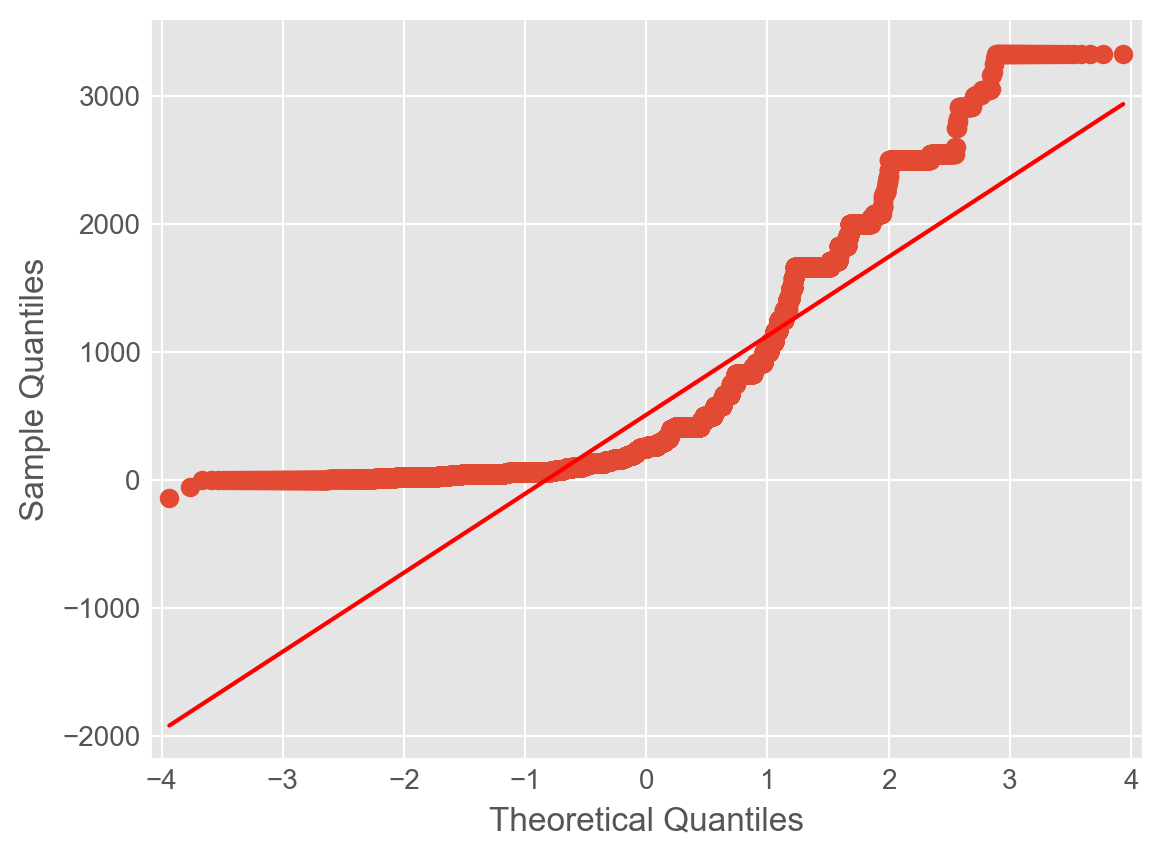

In [67]:
#use Shapiro test to check for normality of payment_amt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
stat, p = shapiro(df['payment_amt'])
print('Shapiro Statistics=%.3f, p=%.3f' % (stat, p))
plt.figure(figsize=(3,3)) 
qqplot(df['payment_amt'], line='s')
plt.show()


In [37]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(df[df['payment_code'] == 'DEFAULT']['payment_amt'], df[df['payment_code'] == 'PAYMENT']['payment_amt'])
print('Mann Whitney U Test\n Test Statistic=%.3f, p=%.3f' % (stat, p))


Mann Whitney U Test
 Test Statistic=23044555.500, p=0.096


### Entity Type

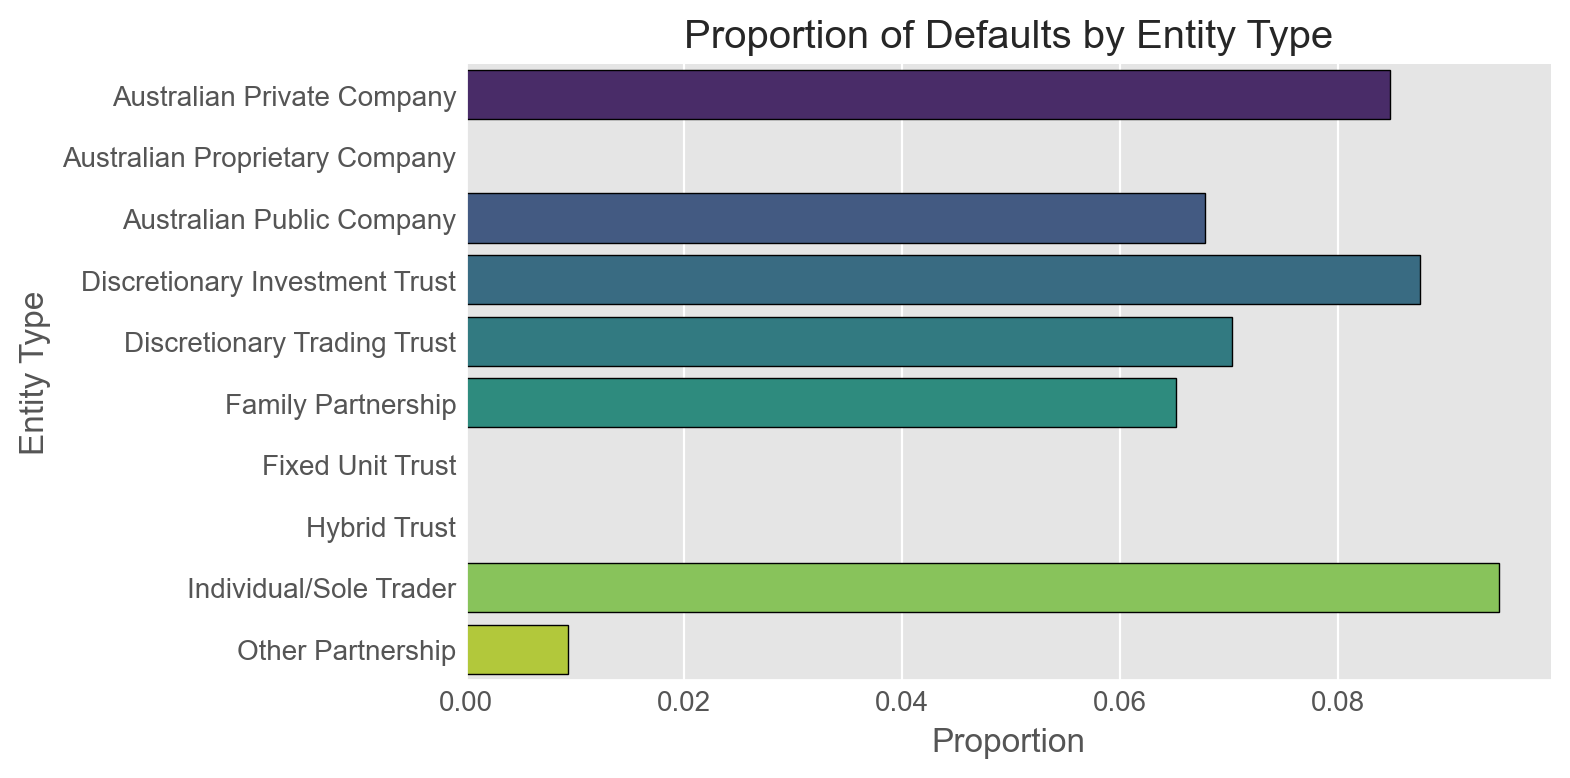

In [91]:

default = df[df.payment_code=='DEFAULT']['entity_type'].value_counts()
total = df['entity_type'].value_counts()
proportion = default/total

plt.figure(figsize=(7,4))
sns.barplot(x=proportion.values, y=proportion.index,palette = 'viridis',edgecolor ='black')
plt.title('Proportion of Defaults by Entity Type')
plt.xlabel('Proportion')
plt.ylabel('Entity Type')
plt.show()

#### Chi-Square Test of Independence
- To determine whether entity type is a good predictor of default, we will use the chi-square test of independence to compare the distribution of entity type between default and non-default groups.
- As seen below, the initial contingency table contains expected counts of < 5, therefore Entity Types are re-categorized into Company, Partnership, Individual and Trust
- The test yields a p-value < 0.05, providing strong evidence to reject the null hypothesis that employment status and course option is independent.

In [70]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(df['entity_type'], df['payment_code'])
contingency_table

payment_code,DEFAULT,PAYMENT
entity_type,,
Australian Private Company,1195,12547
Australian Proprietary Company,0,4
Australian Public Company,8,105
Discretionary Investment Trust,7,73
Discretionary Trading Trust,18,220
Family Partnership,49,676
Fixed Unit Trust,0,53
Hybrid Trust,0,13
Individual/Sole Trader,865,8085


In [68]:
chisqdf = df.replace({
    'entity_type': {
        'Australian Private Company': 'Company',
        'Australian Proprietary Company': 'Company', 
        'Australian Public Company': 'Company', 
        'Discretionary Investment Trust': 'Trust', 
        'Discretionary Trading Trust': 'Trust', 
        'Fixed Unit Trust': 'Trust', 
        'Hybrid Trust': 'Trust',
        'Family Partnership': 'Partnership', 
        'Other Partnership': 'Partnership'
    }
})

contingency_table = pd.crosstab(chisqdf['payment_code'], chisqdf['entity_type'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print('Test Statistic:', chi2)
print('P-value:', p)
print('Degrees of freedom:', dof)
contingency_table


Test Statistic: 23.0911881124264
P-value: 3.8653643279345065e-05
Degrees of freedom: 3


entity_type,Company,Individual/Sole Trader,Partnership,Trust
payment_code,,,,
DEFAULT,1203,865,51,25
PAYMENT,12656,8085,874,359


### Year of Establishment
- Another variable of interest is year of establishment, as companies that are older may be more stable and less likely to default. As seen below the mean years of establishment for default is slightly lower than non-default
- 

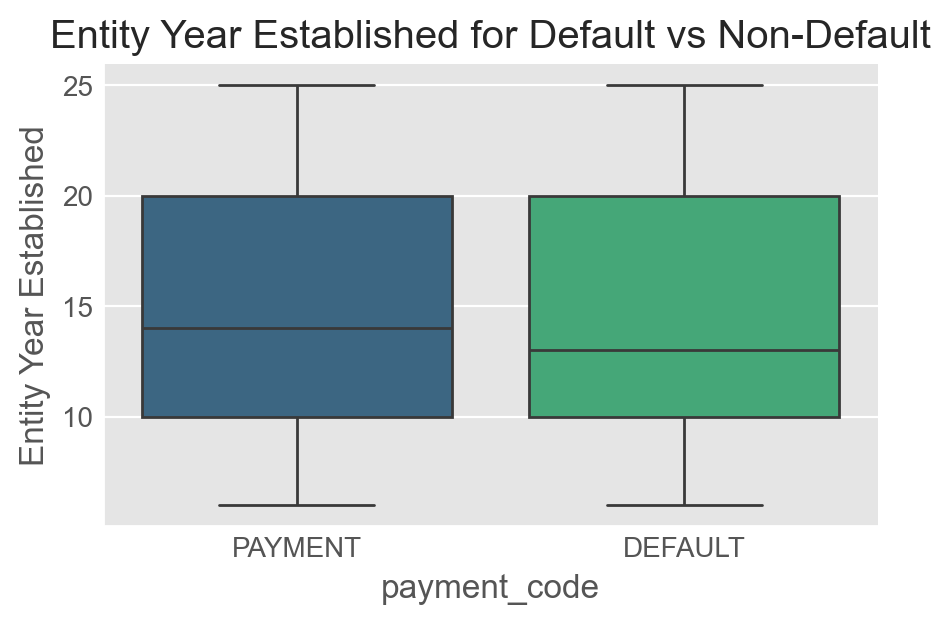

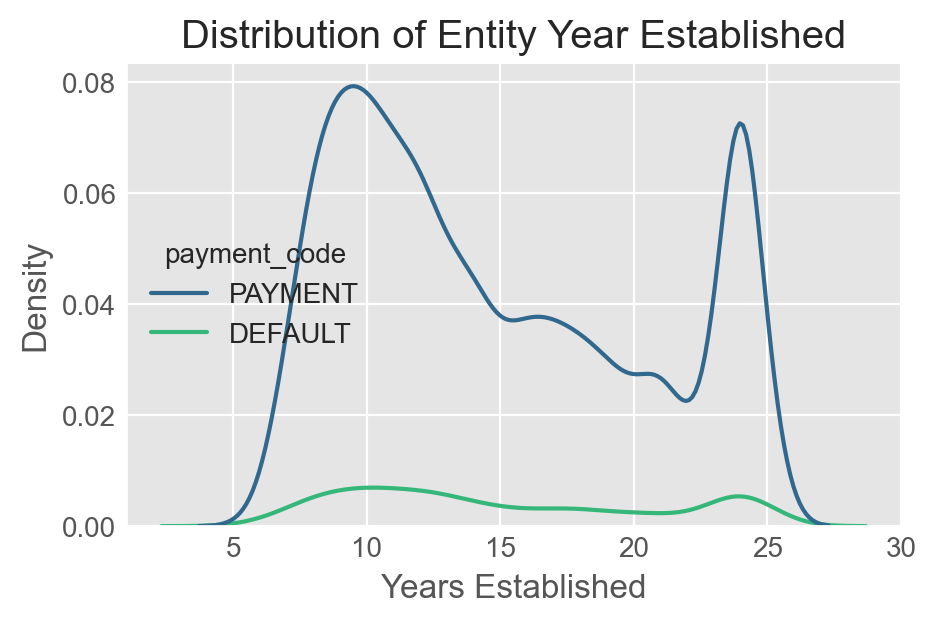

In [94]:
#transform entity_year_established to a number of years, subtracting the year from this year
df['entity_year_established'] = dt.datetime.now().year - df['entity_year_established']
df['entity_year_established'] = df['entity_year_established'].astype('float')

plt.figure(figsize=(5,3))
sns.boxplot(data=df, x='payment_code', y='entity_year_established', palette='viridis')
plt.ylabel('Entity Year Established')
plt.title('Entity Year Established for Default vs Non-Default')
plt.show()

plt.figure(figsize=(5,3))
sns.kdeplot(data=df, x='entity_year_established', hue='payment_code', palette='viridis')
plt.title('Distribution of Entity Year Established')
plt.xlabel('Years Established')
plt.show()

Shapiro Statistics=0.909, p=0.000


<Figure size 300x300 with 0 Axes>

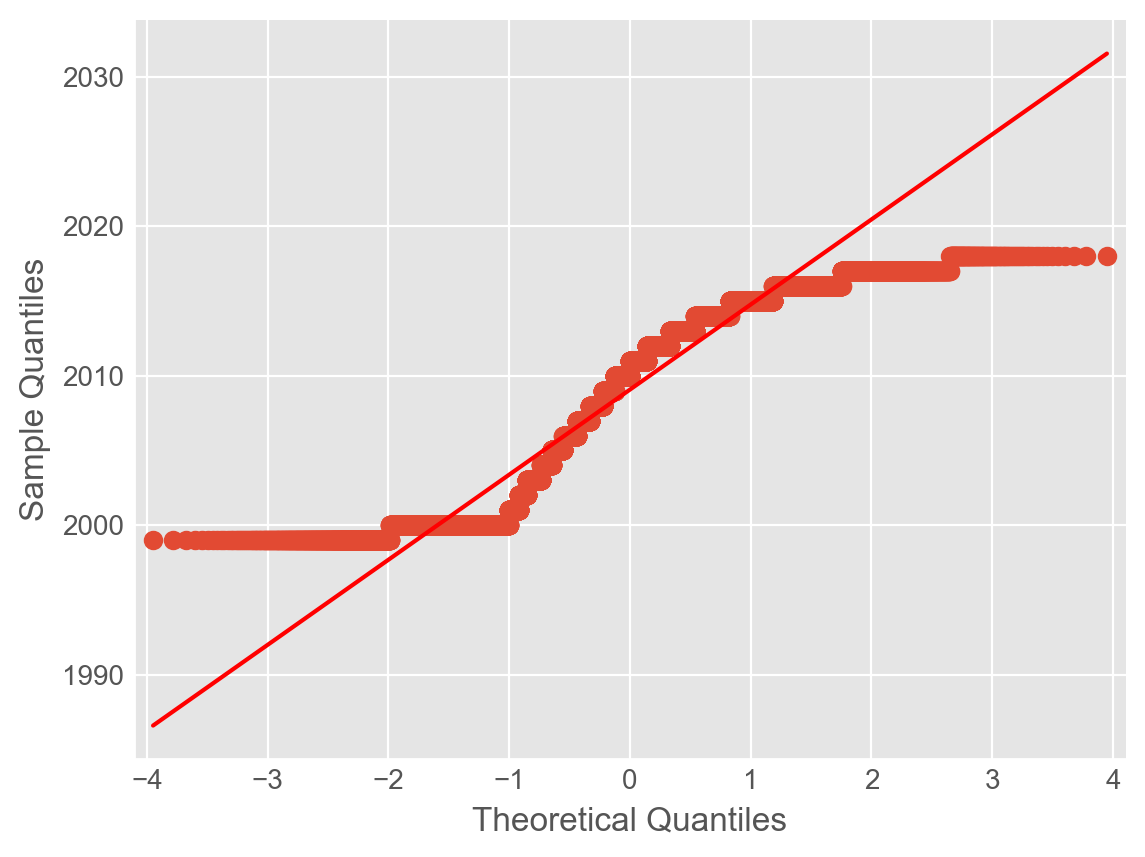

In [82]:
#qqplot of entity_year_established
stat, p = shapiro(df['entity_year_established'])
print('Shapiro Statistics=%.3f, p=%.3f' % (stat, p))
plt.figure(figsize=(3,3))
qqplot(df['entity_year_established'], line='s')
plt.show()

#### Wilcoxon Rank Sum Test
- To determine whether organizations who defaulted have lower years of establishment, we will compare the years of establishment between default and non-default groups.
- Again, as the data is not normally distributed, we will use the Wilcoxon Rank Sum Test to compare the years of establishment between default and non-default groups.
- Two groups follow similar distributions, as observed from the boxplot
- The test yields a p-value of > 0.05, providing no evidence to reject the null hypothesis that the years of establishment are the same between default and non-default groups.

In [90]:
stat, p = mannwhitneyu(df[df['payment_code'] == 'DEFAULT']['entity_year_established'], df[df['payment_code'] == 'PAYMENT']['entity_year_established'], alternative='less')

print('Mann Whitney U Test\n Test Statistic=%.3f, p=%.3f' % (stat, p))


Mann Whitney U Test
 Test Statistic=25602960.500, p=0.188


## Logistic Regression
- While the above tests gives a better understanding of the relationship among variables, a logistic regression model will be used to predict the probability of default
- Model specification is selected through AIC-based stepwise selection
